In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import math
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [83]:
DATA_PATH = "/kaggle/input/office-script1/office_script_clean.txt"

with open(DATA_PATH, "r", encoding="utf-8") as f:
    text = f.read()
text = text[:1_500_000]
print(f"using {len(text):,} chars")


using 1,500,000 chars


In [84]:
chars = sorted(set(text))
vocab_size = len(chars)

stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

def encode(s):
    return [stoi[c] for c in s]

def decode(ids):
    return "".join(itos[i] for i in ids)

print("vocab size:", vocab_size)


vocab size: 72


In [85]:
SEQ_LEN = 64

sequences = []
for i in range(0, len(text) - SEQ_LEN, SEQ_LEN):
    sequences.append(encode(text[i:i+SEQ_LEN+1]))

print(f"got {len(sequences):,} sequences")

split = int(0.9 * len(sequences))
train_seqs = sequences[:split]
val_seqs   = sequences[split:]

print(f"train: {len(train_seqs):,}, val: {len(val_seqs):,}")


got 23,437 sequences
train: 21,093, val: 2,344


In [86]:
EMB = 64
HID = 128

class CharLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, EMB)
        self.lstm = nn.LSTM(EMB, HID, batch_first=True)
        self.fc = nn.Linear(HID, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        return self.fc(out)

model = CharLSTM().to(DEVICE)
print(f"model: {EMB} -> {HID} -> {vocab_size}")


model: 64 -> 128 -> 72


In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
criterion = nn.CrossEntropyLoss()

EPOCHS = 3000
BATCH_SIZE = 24

print(f"epochs: {EPOCHS}, batch: {BATCH_SIZE}, lr: 0.006")


epochs: 3000, batch: 24, lr: 0.006


In [88]:
hist = {"tp": [], "vp": []}
print("starting training")

for epoch in range(EPOCHS):
    warmup = 2
    if epoch < warmup:
        lr = 0.006 * (epoch + 1) / warmup
    else:
        p = (epoch - warmup) / (EPOCHS - warmup)
        lr = 0.001 + (0.006 - 0.001) * 0.5 * (1 + math.cos(math.pi * p))

    for g in optimizer.param_groups:
        g["lr"] = lr

    random.shuffle(train_seqs)

    nbatches = min(len(train_seqs) // BATCH_SIZE, 40)
    if nbatches == 0:
        nbatches = 1

    model.train()
    total_loss = 0.0

    for b in range(nbatches):
        batch = train_seqs[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        x = torch.tensor([s[:-1] for s in batch], device=DEVICE)
        y = torch.tensor([s[1:]  for s in batch], device=DEVICE)

        logits = model(x)
        loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / nbatches
    train_ppl = math.exp(min(avg_loss, 10))

   
    if epoch < 2 or epoch % 5 == 0 or epoch == EPOCHS - 1:
        model.eval()
        with torch.no_grad():
            vl = 0.0
            for s in val_seqs[:50]:
                x = torch.tensor(s[:-1], device=DEVICE).unsqueeze(0)
                y = torch.tensor(s[1:],  device=DEVICE).unsqueeze(0)
                logits = model(x)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                vl += loss.item()
            vl /= 50
            val_ppl = math.exp(min(vl, 10))
    else:
        val_ppl = hist["vp"][-1]

    hist["tp"].append(train_ppl)
    hist["vp"].append(val_ppl)

    print(f"epoch {epoch+1}/{EPOCHS}: ppl={train_ppl:.2f}, val={val_ppl:.2f}, lr={lr:.4f}")

print(f"\nbest val ppl: {min(hist['vp']):.2f}")


starting training
epoch 1/3000: ppl=21.85, val=11.44, lr=0.0030
epoch 2/3000: ppl=9.63, val=6.97, lr=0.0060
epoch 3/3000: ppl=7.46, val=6.97, lr=0.0060
epoch 4/3000: ppl=6.55, val=6.97, lr=0.0060
epoch 5/3000: ppl=6.04, val=6.97, lr=0.0060
epoch 6/3000: ppl=5.77, val=4.67, lr=0.0060
epoch 7/3000: ppl=5.54, val=4.67, lr=0.0060
epoch 8/3000: ppl=5.39, val=4.67, lr=0.0060
epoch 9/3000: ppl=5.27, val=4.67, lr=0.0060
epoch 10/3000: ppl=5.03, val=4.67, lr=0.0060
epoch 11/3000: ppl=5.03, val=4.12, lr=0.0060
epoch 12/3000: ppl=4.91, val=4.12, lr=0.0060
epoch 13/3000: ppl=4.89, val=4.12, lr=0.0060
epoch 14/3000: ppl=4.80, val=4.12, lr=0.0060
epoch 15/3000: ppl=4.78, val=4.12, lr=0.0060
epoch 16/3000: ppl=4.74, val=3.92, lr=0.0060
epoch 17/3000: ppl=4.69, val=3.92, lr=0.0060
epoch 18/3000: ppl=4.61, val=3.92, lr=0.0060
epoch 19/3000: ppl=4.54, val=3.92, lr=0.0060
epoch 20/3000: ppl=4.61, val=3.92, lr=0.0060
epoch 21/3000: ppl=4.56, val=3.70, lr=0.0060
epoch 22/3000: ppl=4.58, val=3.70, lr=0.0060

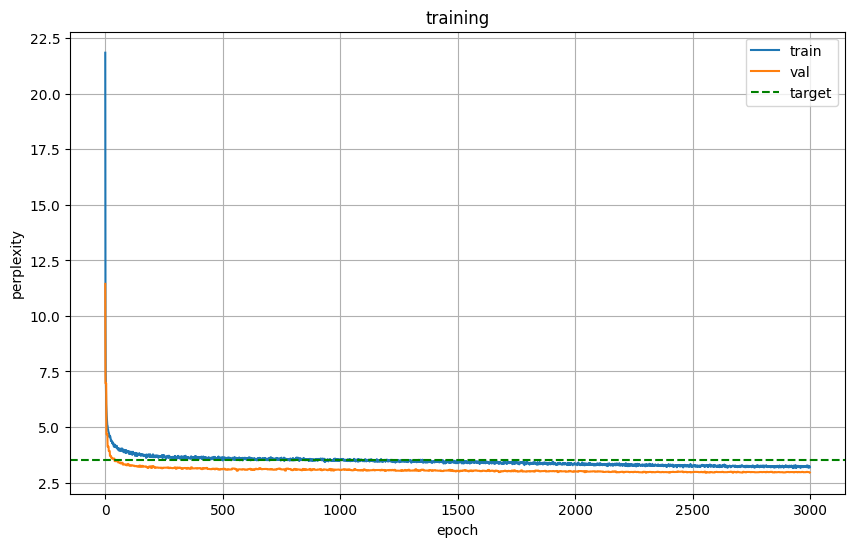

In [89]:
plt.figure(figsize=(10,6))
plt.plot(hist["tp"], label="train")
plt.plot(hist["vp"], label="val")
plt.axhline(3.5, color="green", linestyle="--", label="target")
plt.xlabel("epoch")
plt.ylabel("perplexity")
plt.title("training")
plt.legend()
plt.grid(True)
plt.show()


In [90]:
def generate(seed_text, temp=0.7, steps=500):
    model.eval()
    seed = encode(seed_text)
    h = None
    x = torch.tensor(seed, device=DEVICE).unsqueeze(0)

    with torch.no_grad():
        for _ in range(steps):
            emb = model.embed(x)
            out, h = model.lstm(emb, h)
            logits = model.fc(out[:, -1])
            probs = F.softmax(logits / temp, dim=-1)
            idx = torch.multinomial(probs, 1)
            x = torch.cat([x, idx], dim=1)

    return seed_text + decode(x[0].tolist()[len(seed):])


In [91]:
seed = "Michael: Hey Shaurya"
temps = [0.3, 0.7, 1.0]

for t in temps:
    print("\nTemperature:", t)
    print("-" * 70)
    print(generate(seed, temp=t)[:400])



Temperature: 0.3
----------------------------------------------------------------------
Michael: Hey Shauryal.
Michael: I don't know.
Michael: I want you to take the way that I was a little thing in the party with the doctor can have to do it.
Michael: Yeah.
Michael: I don't know what you want to have a business to the condo.
Michael: And you can do that to the same the most salesman and I was the phone.
Michael: No, I want you to be a same than the control. I think they're here. I a

Temperature: 0.7
----------------------------------------------------------------------
Michael: Hey Shauryal last year, I really wanted to do this.
Michael: Um...
Kelly: Oh yeah.
Jim: That's all day revoom.
Angela: Don't pay and so we don't have to be mean, and their hours.
Michael: I can talk to fire, what has got a few my house to be a seat.
Jim: It's really under you at the time on the cheese thing to be a really cool. That's what you should go to the world. 
Jim: I am going to b

Temperature: 1.0
--